# Compute regridding weights and write to file

Requires esmpy-7.1.0.dev38 at https://anaconda.org/NESII/esmpy/files. Can be installed by

    conda install -c nesii/label/dev-esmf -c conda-forge esmpy==7.1.0.dev38

This notebook also includes the timing of applying weights with ESMPy. For the timing of applying weights with pure Python, see [apply_weights.ipynb](apply_weights.ipynb) .

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import ESMF
import xesmf as xe

## Make input and output grids

In [4]:
ds_in = xe.util.grid_2d(-120, 120, 0.4,
                   -60, 60, 0.3)
ds_in

<xarray.Dataset>
Dimensions:  (x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [5]:
ds_out = xe.util.grid_2d(-120, 120, 0.6,
                    -60, 60, 0.4)
ds_out

<xarray.Dataset>
Dimensions:  (x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 -117.3 -116.7 -116.1 ...
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 -118.2 -117.6 -117.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

## Create ESMPy grid object

In [9]:
ds_in.T['lon'].values.flags["F_CONTIGUOUS"]

True

In [10]:
# Pass a tranpose. ESMPy prefer Fortran indexing
sourcegrid = xe.util.ds_to_ESMFgrid(ds_in)
destgrid = xe.util.ds_to_ESMFgrid(ds_out)

## Create ESMPy field object

In [11]:
# to test broadcasting across extra dimensions
extra_dims = [50, 10]  
sourcefield = ESMF.Field(sourcegrid, ndbounds=extra_dims)
destfield = ESMF.Field(destgrid, ndbounds=extra_dims)

# ESMPy stacks extra dimensions to the right
sourcefield.data.shape, destfield.data.shape

((600, 400, 50, 10), (400, 300, 50, 10))

## Compute regridding weights and write to file

In [12]:
# rm weights.nc # ESMPy will complain if the weight file already exists

In [13]:
%%time
# extra dimensions affect this online regridding object `regrid`, 
# but has no effect on the offline weight file
regrid = ESMF.Regrid(sourcefield, destfield, filename='weights.nc',
                     regrid_method = ESMF.RegridMethod.BILINEAR,
                     unmapped_action = ESMF.UnmappedAction.IGNORE)

CPU times: user 6.92 s, sys: 335 ms, total: 7.26 s
Wall time: 7.3 s


## Create input data field for testing

In [14]:
Nlon_in, Nlat_in, Nlev, Ntime = sourcefield.data.shape
Nlon_in, Nlat_in, Nlev, Ntime # typical fortran ordering

(600, 400, 50, 10)

In [15]:
# add time and level coordinates
ds_in.coords['time'] = np.arange(1, Ntime+1)
ds_in.coords['lev'] = np.arange(1, Nlev+1)
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [16]:
# Make a 4D data field.

# wave-like 2D field 
wave = lambda x,k:  np.sin(x*k*np.pi/180.0)
wave2d = 1.0 + wave(ds_in['lon'], 4) * wave(ds_in['lat'], 3)

# let it increases linearly with time and lev to test broadcasting
ds_in['data'] = ds_in['time'] * ds_in['lev'] * wave2d
ds_in

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 600, x_b: 601, y: 400, y_b: 401)
Coordinates:
    lon      (y, x) float64 -119.8 -119.4 -119.0 -118.6 -118.2 -117.8 -117.4 ...
    lat      (y, x) float64 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 -59.85 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.6 -119.2 -118.8 -118.4 -118.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (time, lev, y, x) float64 1.007 1.007 1.007 1.007 1.007 1.007 ...

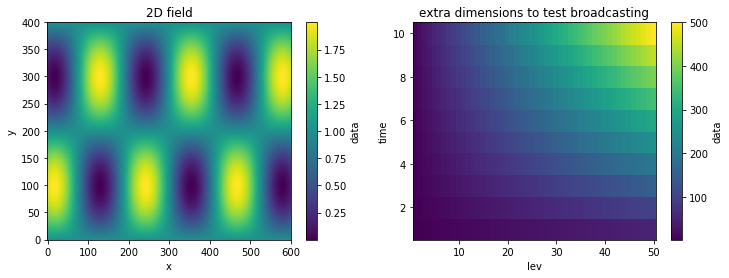

In [17]:
plt.figure(figsize=[12,4])
plt.subplot(121);ds_in['data'].isel(time=0, lev=0).plot()
plt.title('2D field')
plt.subplot(122);ds_in['data'].mean(dim=['x','y']).plot()
plt.title('extra dimensions to test broadcasting')


In [18]:
ds_in.data.shape # typical ordering of real data

(10, 50, 400, 600)

## Use ESMPy to apply regrid weights (call underlying Fortran routine)

### Tweak array ordering

Numpy array are typically C-ordered:

In [19]:
ds_in['data'].values.shape

(10, 50, 400, 600)

In [20]:
ds_in['data'].values.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

But ESMPy uses Fortran-ordering

In [21]:
sourcefield.data.shape

(600, 400, 50, 10)

In [22]:
sourcefield.data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [23]:
ds_in['data'].values.T.shape

(600, 400, 50, 10)

In [24]:
ds_in['data'].values.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

Passing Fortran-ordered array is fast. Passing C-ordered array would be extremely slow because of memory re-ordering.

In [25]:
# transfer data to ESMPy internal
%time sourcefield.data[...] = ds_in['data'].values.T

CPU times: user 230 ms, sys: 239 ms, total: 469 ms
Wall time: 469 ms


In [26]:
# cannot avoid memory duplication for input
np.may_share_memory(sourcefield.data, ds_in['data'].values.T)

False

### Apply regridding

In [27]:
destfield.data.max() # destination field is 0 before regridding

0.0

In [29]:
# apply regridding weights
# cannot use @timeit here, just rerun multiple times
%time destfield = regrid(sourcefield, destfield)

CPU times: user 1.72 s, sys: 9.42 ms, total: 1.73 s
Wall time: 1.74 s


In [30]:
destfield.data.shape

(400, 300, 50, 10)

In [31]:
destfield.data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [32]:
destfield.data.T.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [33]:
# add to DataSet so it is easier to plot
ds_out.coords['time'] = ds_in['time']
ds_out.coords['lev'] = ds_in['lev']
ds_out['data'] = (('time', 'lev', 'y', 'x'), destfield.data.T)
ds_out

<xarray.Dataset>
Dimensions:  (lev: 50, time: 10, x: 400, x_b: 401, y: 300, y_b: 301)
Coordinates:
    lon      (y, x) float64 -119.7 -119.1 -118.5 -117.9 -117.3 -116.7 -116.1 ...
    lat      (y, x) float64 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 -59.8 ...
    lon_b    (y_b, x_b) float64 -120.0 -119.4 -118.8 -118.2 -117.6 -117.0 ...
    lat_b    (y_b, x_b) float64 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 -60.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    data     (time, lev, y, x) float64 1.009 1.009 1.01 1.01 1.01 1.01 1.01 ...

In [34]:
# no memory duplication for output
np.may_share_memory(ds_out['data'].values, destfield.data.T)

True

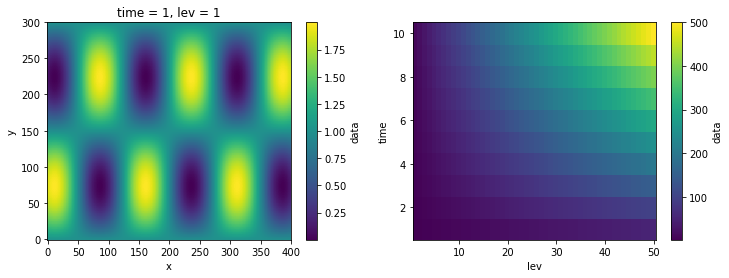

In [35]:
# both 2D regridding and broadcasting are working correctly
plt.figure(figsize=[12,4])
plt.subplot(121);ds_out['data'].isel(time=0, lev=0).plot()
plt.subplot(122);ds_out['data'].mean(dim=['x','y']).plot()

# Write input and output data to file

In [36]:
%time ds_in.to_netcdf('input_data.nc')

CPU times: user 18.4 ms, sys: 374 ms, total: 392 ms
Wall time: 462 ms


In [37]:
%time ds_out.to_netcdf('output_data.nc')

CPU times: user 10.1 ms, sys: 212 ms, total: 222 ms
Wall time: 411 ms
